# HBDSCAN
---
**Learning notes**
- Method based on density.
- Unlike K-Means, it does not assume hyper-spherical clusters

## Env Preparation

In [1]:
import os
import sys
os.chdir('/app/')
print(os.getcwd())
from os.path import join as JP
sys.path.append(os.getcwd())
sys.path.append(JP(os.getcwd(),'utils'))
sys.path.append(JP(os.getcwd(),'scripts'))

/app


In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.3f}'.format

In [5]:
import pickle
from pprint import pprint
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

## Data

In [6]:
data = pd.read_csv(JP('data','bbc-text-processed.csv')).iloc[:,1:]
data.head()

,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,806,tv future hand viewer system plasma high defin...
1,business,worldcom boss left books alone former worldc...,332,left book ebber accuse oversee 11bn fraud acco...
2,sport,tigers wary of farrell gamble leicester say ...,270,wary farrell gamble rush make bid decide switc...
3,sport,yeading face newcastle in fa cup premiership s...,390,yeade face premiership face trip leader yeade ...
4,entertainment,ocean s twelve raids box office ocean s twelve...,287,raid ocean crime go number office chart take w...


## TFIDF

In [7]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
EMBED_SIZE = 10000        # TODO: Increase
NUM_CLUSTERS = data['category'].nunique()
WORDS_PER_CLUSTER = None
print(NUM_CLUSTERS)

5


In [12]:
vectorizer = TfidfVectorizer(
    min_df=.05,
    max_df=.9,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Moving to a Catalog Format

In [13]:
documents = [Document() for i in range(data.shape[0])]
for d in range(len(documents)):
    documents[d].processed_text = data['processed'][d]

In [14]:
catalog = Catalog()
catalog.documents = documents

In [15]:
_ = catalog.collect_corpus(attr='processed_text', form=list)
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

(2225, 461)


,able,accept,access,accord,account,accuse,act,action,add,admit,...,week,weekend,win,winner,woman,work,world,write,year,young
0,0.000,0.000,0.000,0.037,0.000,0.000,0.000,0.000,0.027,0.000,...,0.000,0.000,0.000,0.000,0.000,0.029,0.000,0.000,0.038,0.000
1,0.000,0.000,0.000,0.000,0.000,0.150,0.000,0.000,0.000,0.299,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.239,0.066,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.115,0.000,0.000,0.000,0.000,0.000,0.000,...,0.093,0.315,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Dimensionality Reduction

### PCA

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data_lowD = pca.fit_transform(tfidf.representation.values)
print('The {} records have been embedded into {} dimensions'.format(*data_lowD.shape))

The 2225 records have been embedded into 3 dimensions


### UMAP

In [71]:
import umap
umap_ = umap.UMAP(random_state=42, n_components=2, metric='cosine')
umap_3_ = umap.UMAP(random_state=42, n_components=3, metric='cosine')
umap_embedding = umap_.fit_transform(tfidf.representation.values)
umap_embedding_3 = umap_3_.fit_transform(tfidf.representation.values)
print('The {} records have been embedded into {} dimensions'.format(*umap_embedding.shape))

The 2225 records have been embedded into 2 dimensions


## HDBSCAN vs PCA + HDBSCAN vs UMAP + HDBSCAN
HDBSCAN is a density based algorithm, which works with the flixibility of:
- Allowing points to be noise, not belonging to any cluster
- Allow the data to shape the clusters, rather that assume they are spherical  

**Between these variants:**
- Not performing dimensionality reduction is bad. HDBSCAN suffers a lot from the course of dimensionality
- PCA is a linear dimensionality reduction via projections. 
- UMAP perfmorm non-linear manifold aware dimension reduction, perfect for applying HDBSCAN afterwards

In [72]:
import hdbscan
hbdscan_clustering = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500)
hbdscan_clustering_lowD = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500)
hbdscan_clustering_umap = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500)
hbdscan_clustering_umap_3 = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500)

In [73]:
clusters = hbdscan_clustering.fit_predict(tfidf.representation.values)
pd.value_counts(np.array(clusters))

-1    2225
dtype: int64

In [74]:
clusters_lowD = hbdscan_clustering_lowD.fit_predict(data_lowD)
pd.value_counts(np.array(clusters_lowD))

-1    2225
dtype: int64

In [75]:
clusters_umap = hbdscan_clustering_umap.fit_predict(umap_embedding)
pd.value_counts(np.array(clusters_umap))

 1    1253
 0     948
-1      24
dtype: int64

In [76]:
clusters_umap_3 = hbdscan_clustering_umap.fit_predict(umap_embedding_3)
pd.value_counts(np.array(clusters_umap_3))

 0    965
 1    638
 2    561
-1     61
dtype: int64

## Visualization

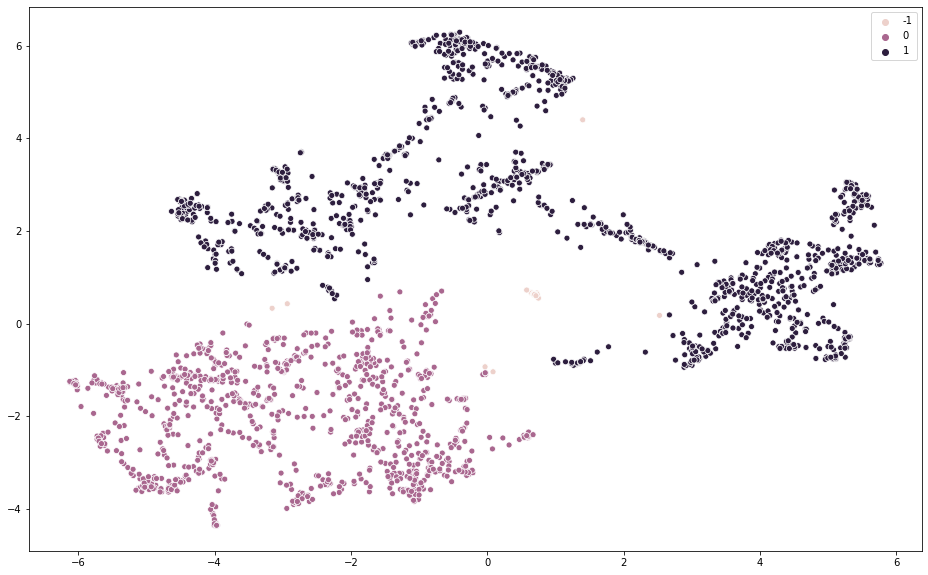

In [77]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=umap_embedding[:,0], y=umap_embedding[:,1], hue=clusters_umap)

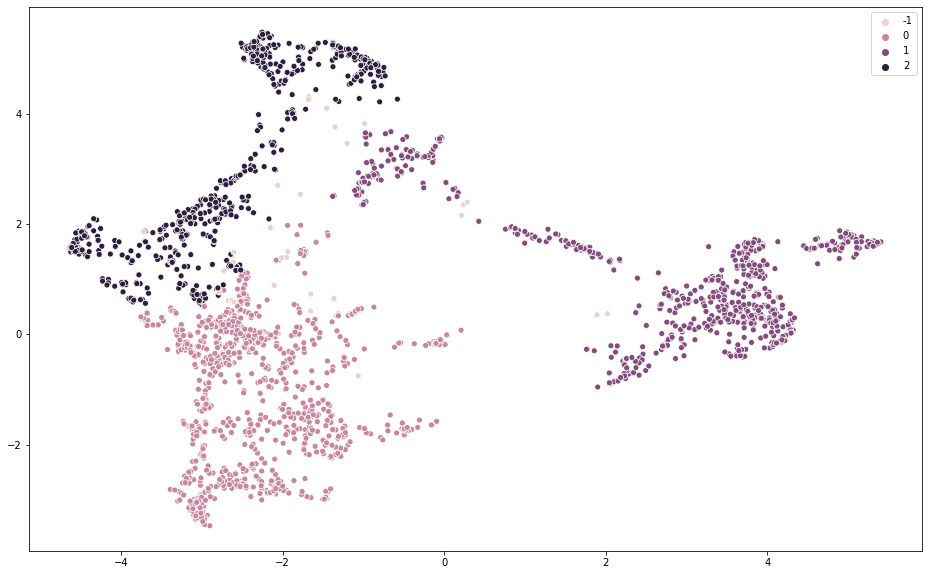

In [78]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=umap_embedding_3[:,0], y=umap_embedding_3[:,1], hue=clusters_umap_3)

In [81]:
df = pd.DataFrame(
    data=np.hstack((umap_embedding_3, clusters_umap_3.reshape(-1,1))), 
    columns=['umap_1', 'umap_2', 'umap_3', 'clusters'])
df

,umap_1,umap_2,umap_3,clusters
0,-2.479,2.952,-1.210,2.000
1,-1.197,-0.530,-0.968,0.000
2,2.132,-0.844,-1.062,1.000
3,3.386,0.781,-0.541,1.000
4,-2.176,5.421,-0.144,2.000
...,...,...,...,...
2220,-2.526,-2.758,-2.218,0.000
2221,-2.263,-0.068,1.785,0.000
2222,-0.253,2.660,-1.854,1.000
2223,-2.518,0.298,0.511,0.000


In [82]:
fig = px.scatter_3d(df, x='umap_1', y='umap_2', z='umap_3', color='clusters')
fig.update_traces(marker=dict(size=3))
fig.show()

---

# Plotting the WordClouds


In [27]:
%matplotlib inline
from wordcloud import WordCloud

#### Helper Functions for Plotting

In [28]:
def define_subplots(n_cols,n_plots,figsize=None):
    '''Return the axes given a total 
    of plots and desired number of columns'''
    j = 1 if n_plots%n_cols != 0 else 0
    n_rows = (n_plots // n_cols) + j 
    
    if not figsize: 
        figsize=(n_cols*5,n_rows*5)
    
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, sharex=False, sharey=False,
        figsize=figsize)
    return fig,axs # .reshape(n_plots,-1)

In [29]:
def cluster_to_wordcloud(
    df, max_words=200, use_mask=False, bgcolor='black'):
    ''' Convert 1 cluster into a WordCloud given:
        - The TFIDF for the cluster
        - The Score Method that give imporance to the word '''
    # Create the wordcloud attending to the inverse of idf
    wordcloud = WordCloud(
        max_words=max_words, 
        mask=mask_ if use_mask else None,
        background_color=bgcolor).generate_from_frequencies(
            frequencies=dict(zip(df.word, df.score)))
    return wordcloud


In [30]:
def plot_centroids_as_wordclouds(
    word_scores,
    NUM_CLUSTERS = None,
    max_words_per_cloud=100, 
    use_mask=False, n_cols=2, figsize=(15,15)):

    if not NUM_CLUSTERS:
        NUM_CLUSTERS = word_scores.cluster.nunique()

    n_plots = NUM_CLUSTERS
    _, axs = define_subplots(n_cols,n_plots, figsize)
    
    for c in range(NUM_CLUSTERS):
        wordcloud = cluster_to_wordcloud(
            df=word_scores[word_scores.cluster == c+1],
            max_words=max_words_per_cloud,
            use_mask=use_mask)
        
        # Plot the resulting wordcloud
        axs[c // n_cols, c % n_cols].imshow(wordcloud)
        axs[c // n_cols, c % n_cols].axis('off')
    plt.tight_layout()
    plt.show()
    return


### Data to desired format

In [54]:
scores = pd.melt(centroids.rename_axis('cluster').reset_index(), 
                 id_vars=['cluster'], var_name='word', value_name='score')

In [52]:
scores.head(10)

,cluster,word,score
0,1,able,0.010
1,2,able,0.006
2,3,able,0.005
3,4,able,0.014
4,5,able,0.012
5,1,accept,0.002
6,2,accept,0.005
7,3,accept,0.006
8,4,accept,0.008
9,5,accept,0.009


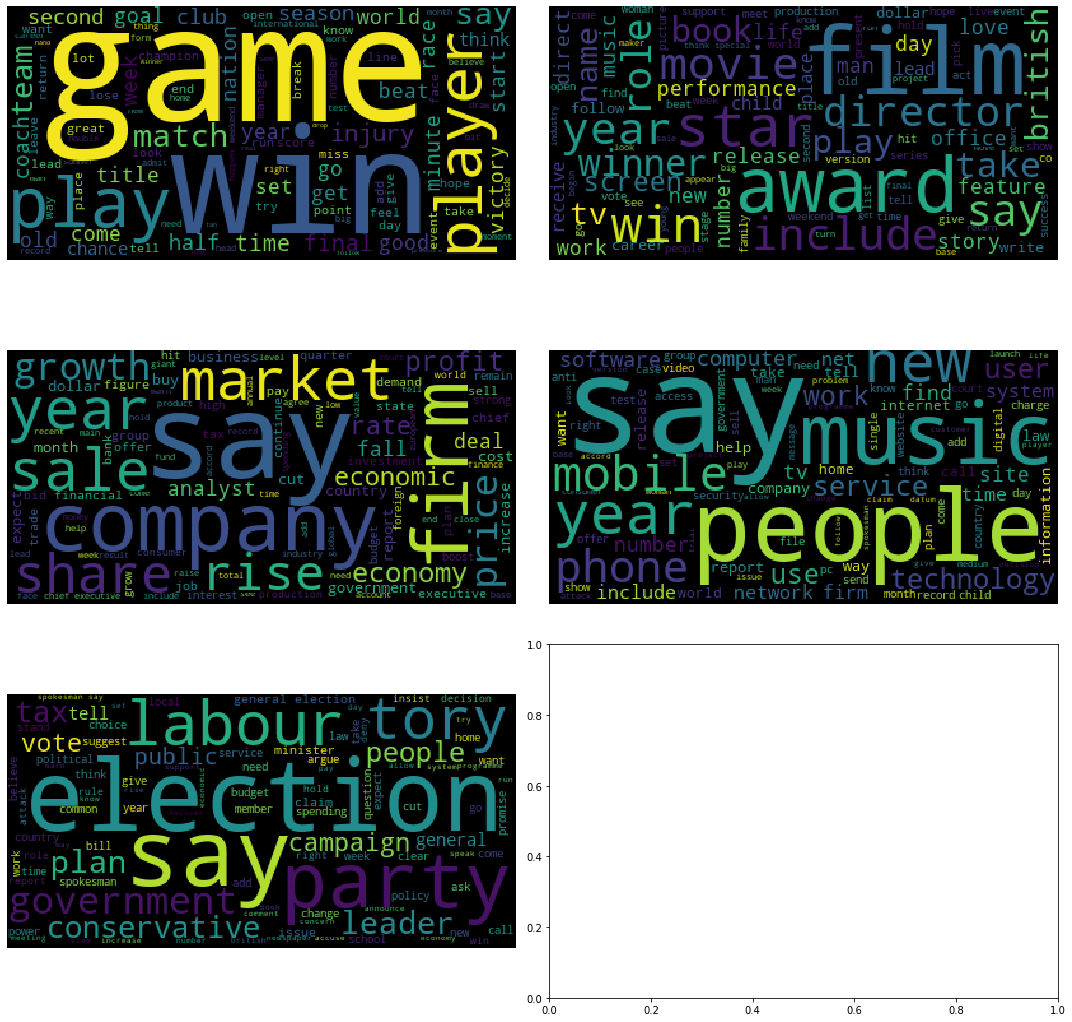

In [32]:
plot_centroids_as_wordclouds(scores, n_cols=2)

# Validation

**According to importants words of cluster lets assigned a classification:**

In [142]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [86]:
cluster_preds = ['sport', 'entertainment', 'business', 'tech', 'politics']  
d = dict(zip(range(NUM_CLUSTERS), cluster_preds))
d

{0: 'sport', 1: 'entertainment', 2: 'business', 3: 'tech', 4: 'politics'}

In [87]:
data['predict'] = [d[i] for i in clusters.labels_]

In [88]:
print(data.category.value_counts())

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


In [89]:
print(data.predict.value_counts())

tech             767
sport            510
business         481
politics         256
entertainment    211
Name: predict, dtype: int64


In [90]:
cm = confusion_matrix(
    y_true=data.category, 
    y_pred = data.predict, 
    labels=cluster_preds)

pd.DataFrame(cm, columns=cluster_preds, index=cluster_preds)

,sport,entertainment,business,tech,politics
sport,454,4,1,52,0
entertainment,8,197,11,170,0
business,1,0,447,56,6
tech,44,10,7,339,1
politics,3,0,15,150,249


## PCA - KMeans

In [91]:
from sklearn.decomposition import PCA

In [92]:
pca = PCA(n_components=50)
pca_output = pca.fit_transform(tfidf.representation.values)
print('Singular Values = ', pca.singular_values_)
print('Explaiend Varaince = ', pca.explained_variance_)
print('Explaiend Varaince Ratio = ', pca.explained_variance_ratio_)
print('The {} have been embedded into {} dimensions'.format(*pca_output.shape))

Singular Values =  [8.177 7.244 6.859 6.331 5.487 5.048 4.928 4.653 4.644 4.513 4.457 4.182
 4.099 4.021 3.933 3.862 3.764 3.737 3.726 3.584 3.563 3.504 3.462 3.398
 3.388 3.357 3.325 3.322 3.269 3.245 3.227 3.218 3.16  3.149 3.117 3.092
 3.06  3.052 3.013 2.998 2.964 2.942 2.928 2.919 2.833 2.828 2.808 2.771
 2.757 2.745]
Explaiend Varaince =  [0.03  0.024 0.021 0.018 0.014 0.011 0.011 0.01  0.01  0.009 0.009 0.008
 0.008 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006 0.006 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.003
 0.003 0.003]
Explaiend Varaince Ratio =  [0.033 0.026 0.023 0.02  0.015 0.013 0.012 0.011 0.011 0.01  0.01  0.009
 0.008 0.008 0.008 0.007 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006
 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004]
The 2225 have

In [127]:
pca_clusters = kmean_clustering(data=pca_output, njobs=1, num_clusters=NUM_CLUSTERS)
# pca_BEST_WORDS_PER_CLUSTER = words_per_cluster(tfidf,clusters)
pca_centroids = get_centroids(tfidf, clusters)

In [135]:
pca_cluster_preds = ['tech', 'sport', 'politics', 'business', 'entertainment']  
d = dict(zip(range(NUM_CLUSTERS), pca_cluster_preds))
d

{0: 'tech', 1: 'sport', 2: 'politics', 3: 'business', 4: 'entertainment'}

In [136]:
data['pca_predict'] = [d[i] for i in pca_clusters.labels_]

In [137]:
print(data.category.value_counts())

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


In [138]:
print(data.predict.value_counts())

tech             767
sport            510
business         481
politics         256
entertainment    211
Name: predict, dtype: int64


In [139]:
print(data.pca_predict.value_counts())

sport            657
business         526
politics         471
tech             356
entertainment    215
Name: pca_predict, dtype: int64


**Confusion Matrix with PCA**

In [143]:
cm = confusion_matrix(
    y_true=data.category, 
    y_pred = data.pca_predict, 
    labels=cluster_preds)

print('Accuracy: ', accuracy_score(data.category, data.pca_predict))
pd.DataFrame(cm, columns=cluster_preds, index=cluster_preds)

Accuracy:  0.8453932584269663


,sport,entertainment,business,tech,politics
sport,496,3,2,0,10
entertainment,102,203,24,22,35
business,2,0,469,8,31
tech,53,9,13,322,4
politics,4,0,18,4,391


**Confusion Matrix without PCA**

In [144]:
cm = confusion_matrix(
    y_true=data.category, 
    y_pred = data.predict, 
    labels=cluster_preds)

print('Accuracy: ', accuracy_score(data.category, data.predict))
pd.DataFrame(cm, columns=cluster_preds, index=cluster_preds)

Accuracy:  0.7577528089887641


,sport,entertainment,business,tech,politics
sport,454,4,1,52,0
entertainment,8,197,11,170,0
business,1,0,447,56,6
tech,44,10,7,339,1
politics,3,0,15,150,249
